<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/7.8.%20Adam%E7%AE%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##7.8. Adam算法
Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

###7.8.1. 算法
Adam算法使用了动量变量 $v_t$ 和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量 $s_t$ ，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步 $t$ 的动量变量 $v_t$ 即小批量随机梯度 $g_t $的指数加权移动平均：
$$
\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t.
$$
和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999）， 将小批量随机梯度按元素平方后的项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到 $s_t $：
$$
\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t.
$$
由于我们将 $v_0$ 和 $s_0$ 中的元素都初始化为0， 在时间步 $t$ 我们得到
$\boldsymbol{v}_t = (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到$(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当 $t$ 较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步 $t $，我们可以将$ v_t$ 再除以 $1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量 $v_t$ 和 $s_t$ 均作偏差修正：
$$
\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t},
$$
$$
\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}.
$$
接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{v}}_t$和$\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：
$$
\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},
$$
其中 $\eta$是学习率， $\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-8}$ 。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用 $\boldsymbol{g}_t'$ 迭代自变量：
$$
\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'.
$$


###7.8.2. 从零开始实现
我们按照Adam算法中的公式实现该算法。其中时间步 t 通过hyperparams参数传入adam函数。

In [0]:
%matplotlib inline
import math
import tensorflow as tf
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.data import Dataset
import time,

In [0]:
tf.enable_eager_execution()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
def get_data_ch7():
  data=np.genfromtxt('/content/drive/My Drive/data/d2l-zh-tensoflow/airfoil_self_noise.dat',delimiter='\t')
  data=(data-data.mean(axis=0))/data.std(axis=0)
  return tf.constant(data[:1500,:-1]),tf.constant(data[:1500,-1])
features,labels=get_data_ch7() 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def init_adam_states():
  v_w,v_b=tf.Variable(tf.zeros(shape=(features.shape[1],1),dtype=tf.double)),tf.Variable(tf.zeros(1,tf.double))
  s_w,s_b=tf.Variable(tf.zeros(shape=(features.shape[1],1),dtype=tf.double)),tf.Variable(tf.zeros(1,tf.double))
  return ((v_w,s_w),(v_b,s_b))

In [0]:
def adadelta(params,states,hyperparams,loss,t):
  rho,eps=hyperparams['rho'],1e-5
  for p,(s,delta) in zip(params,states):
    dl_dp=t.gradient(loss,p)
    s.assign(rho*s+(1-rho)*tf.square(dl_dp))
    g=(tf.sqrt((delta+eps))/tf.sqrt((s+eps)))*dl_dp
    p.assign_sub(g)
    delta.assign(rho*delta+(1-rho)*g*g)
def adam(params,states,hyperparams,loss,t):
  beta1,beta2,eps=0.9,0.999,1e-6
  for p,(v,s) in zip(params,states):
    dl_dp=t.gradient(loss,p)
    v.assign(beta1*v+(1-beta1)*dl_dp)
    s.assign(beta2*s+(1-beta2)*tf.square(dl_dp))
    v_bias_corr=v/(1-beta1**hyperparams['t'])
    s_bias_corr=s/(1-beta2**hyperparams['t'])
    p.assign_sub(hyperparams['lr']*v_bias_corr/(tf.sqrt(s_bias_corr)+eps))
  hyperparams['t']+=1

In [0]:
def train_ch7(trainer_fn,states,hyperparams,features,labels,batch_size=10,num_epochs=2):
  net,loss=linreg,squared_loss
  w=tf.Variable(tf.random.normal(stddev=0.01,shape=(features.shape[1],1),dtype=tf.double))
  b=tf.Variable(tf.zeros(1,dtype=tf.double))

  def eval_loss():
    return tf.reduce_mean(loss(net(features,w,b),labels)).numpy()

  ls=[eval_loss()]

  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)

  for _ in range(num_epochs):
    start=time.time()
    for batch_i,(X,y) in enumerate(data_iter):
      with tf.GradientTape(persistent=True) as t:
        t.watch([w,b])
        l=tf.reduce_mean(loss(net(X,w,b),y)) #使用平均损失

      trainer_fn([w,b],states,hyperparams,l,t) #迭代模型参数

      if(batch_i+1)*batch_size %100==0:
        ls.append(eval_loss()) #每100个样本记录下当前训练误差
  # 打印结果和作图
  print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
  set_figsize()
  plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')  


def use_svg_display():
  #用矢量图显示
  display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
  use_svg_display()
  #设置图的尺寸
  plt.rcParams['figure.figsize']=figsize
  
  
def linreg(X,w,b):
  return tf.matmul(X,w)+b 
  
def squared_loss(y_hat,y):
  return (y_hat-tf.reshape(y,shape=y_hat.shape))**2/2    

使用学习率为0.01的Adam算法来训练模型。

loss: 0.246332, 0.595903 sec per epoch


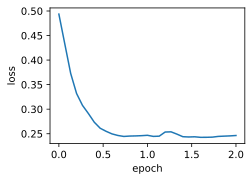

In [0]:
train_ch7(adam,init_adam_states(),{'lr':0.01,'t':1},features,labels)

###7.8.3. 简洁实现

In [0]:
def train_keras_ch7(trainer_name,features,labels,batch_size=10,num_epochs=2):
  net=keras.Sequential(keras.layers.Dense(1))
  loss=losses.MeanSquaredError()
  data_iter=Dataset.from_tensor_slices((features,labels)).shuffle(buffer_size=1000).batch(batch_size)
  net.compile(optimizer=trainer_name,loss=loss,metrics=['mse'])
  history=net.fit_generator(data_iter,epochs=num_epochs)
  loss_ls=history.history['loss']
  set_figsize()
  plt.plot(np.linspace(0,num_epochs,len(loss_ls)),loss_ls)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  return history

Epoch 1/40
150/150 [==============================] - 1s 7ms/step - loss: 2.2897 - mean_squared_error: 2.3970
Epoch 2/40
150/150 [==============================] - 1s 7ms/step - loss: 1.8866 - mean_squared_error: 1.9458
Epoch 3/40
150/150 [==============================] - 1s 7ms/step - loss: 1.6162 - mean_squared_error: 1.6487
Epoch 4/40
150/150 [==============================] - 1s 7ms/step - loss: 1.4144 - mean_squared_error: 1.4315
Epoch 5/40
150/150 [==============================] - 1s 7ms/step - loss: 1.2512 - mean_squared_error: 1.2586
Epoch 6/40
150/150 [==============================] - 1s 7ms/step - loss: 1.1144 - mean_squared_error: 1.1146
Epoch 7/40
150/150 [==============================] - 1s 7ms/step - loss: 0.9986 - mean_squared_error: 0.9929
Epoch 8/40
150/150 [==============================] - 1s 7ms/step - loss: 0.9009 - mean_squared_error: 0.8901
Epoch 9/40
150/150 [==============================] - 1s 7ms/step - loss: 0.8190 - mean_squared_error: 0.8039
Epoch 10/4

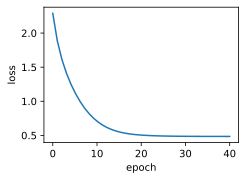

In [0]:
train_keras_ch7(keras.optimizers.Adam(learning_rate=0.001),features,labels,batch_size=10,num_epochs=40)

###7.8.4. 小结
* Adam算法在RMSProp算法的基础上对小批量随机梯度也做了指数加权移动平均。
* Adam算法使用了偏差修正。